In [26]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl


from preconditioners.preconditioners import *
from eki_code.grad_inference import *

In [27]:
np.random.seed(1)

### Test case "Gaussian"

In [68]:
# test case "Gaussian"
xmin = -2
xmax = 2
ymin= -2
ymax= 2

#m = np.asarray([0,0])
#K = np.diag([1,1])
#K_inv = np.linalg.inv(K)
#K_det = np.linalg.det(K)

#coe = 1.0 / ((2 * np.pi)**2 * K_det)**0.5
#I = lambda u: np.linalg.multi_dot([u.T,np.linalg.inv(K),u]) # does not work idny
#I = lambda u: coe * np.e ** (-0.5 * (K_inv[0,0]*(u[0]-m[0])**2 \
#                + (K_inv[0,1] + K_inv[1,0])*(u[0]-m[0])*(u[1]-m[1]) + K_inv[1,1]*(u[1]-m[1])**2))


In [69]:
# potential function

y=0
sigNoise = 0.5
sigPrior = 2

G = lambda u: (u[1])**2+(u[0])**2
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
I = lambda u: Phi(u) + 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2

# C0MPUTE SIGMA POSTERIOR

K_inv = np.eye(d,d)*sigPrior + np.eye(d,d)*sigNoise

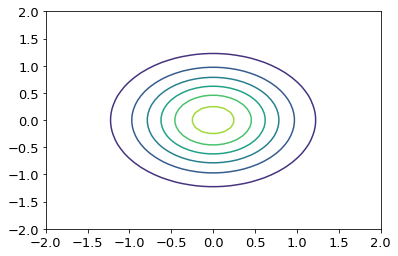

In [64]:
"""
m = np.array([0,0])  # defining the mean of the Gaussian (mX = 0.2, mY=0.6)
cov = np.array([[0.7, 0.4], [0.4, 0.25]])   # defining the covariance matrix
cov_inv = K_inv   # inverse of covariance matrix
cov_det = np.linalg.det(cov)  # determinant of covariance matrix
# Plotting
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
X,Y = np.meshgrid(x,y)
coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))
plt.contour(X,Y,Z)
plt.show()
"""

(2, 150, 150)


Text(0.5, 1.0, 'Posterior distribution')

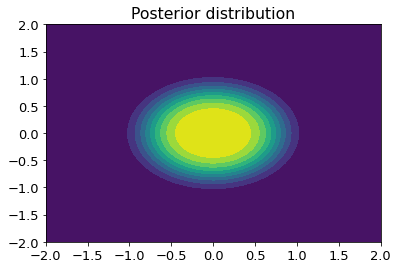

In [70]:
u0s = np.linspace(xmin,xmax,150)
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1))
print(U.shape)


plt.figure()
plt.contourf(U0, U1, np.exp(-I(U)), 10)
plt.title("Posterior distribution")


In [71]:
# method for computing all gradients at once
def compute_gradients(points):
    vs = np.zeros_like(points)
    d, J = points.shape
    H = np.zeros((points.shape[0],points.shape[0],points.shape[1]))
    for i in range(J):
        return_dict= inferGradientAndHess(points, I(points), hessian = True, ind=i, additionalvariance=0.0)
        vs[:,i], H[:,:,i] = return_dict['grad'], return_dict['H']
    return vs, H


### Try algorithms

In [108]:
# parameters of all the algorithms

J = 100  # number of particles 
N_sim = 5000 # number of iterations
d = 2 # dimension
tau = 0.01 # step size
u0 = np.random.normal(0,1.0,(2,J)) # initial position of the particles
alpha = 1 # temperature in langevin? 

# parameters of our algorithm
const = 1.5 


Text(0.5, 1.0, 'Posterior distribution and initialization')

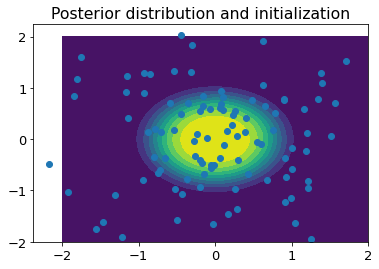

In [109]:

plt.figure()
plt.contourf(U0, U1, np.exp(-I(U)), 10)
plt.scatter(u0[0],u0[1])
plt.title("Posterior distribution and initialization")

In [9]:
start_time = time.time()
us_list_ULA = np.zeros((2,J,N_sim)) # 2, number of particles, number of iterations
us_list_ULA[:,:,0] = u0 # initial positions on the grid


for n in range(N_sim-1):    
    us = us_list_ULA[:,:,n]
    vs, H = compute_gradients(us_list_ULA[:,:,n])
    tauk = tau * np.linalg.norm(us, axis=0)/(1e-3+np.linalg.norm(vs, axis=0))
    us_list_ULA[:,:,n+1] = us_list_ULA[:,:,n] - tauk*alpha*vs + sqrt(2)*(tauk**(1/2))*np.random.normal(0,1,(2,J))

print(f"ULA: {time.time()-start_time} seconds")

ULA: 52.697011947631836 seconds


In [10]:
# EKS (ALDI)
"""
start_time = time.time()
us_list_ALDI = np.zeros((d,J,N_sim))
us_list_ALDI[:,:,0] = u0
total_acc = 0
tau_ALDI = tau


y_algo = np.array([[y]])
for n in range(N_sim-1):   
    us = us_list_ALDI[:,:,n]
    m_us = np.mean(us, axis=1)[:,np.newaxis]
    G_us_unprocessed = G(us)
    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension
    G_us = G_us_unprocessed[np.newaxis,:]
    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]
    #else:
    #    G_us = G_us_unprocessed.T
    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]
    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]
    u_c = us-m_us 
    g_c = G_us- m_G_us
    D = 1/J*np.einsum('ij,lj->il', u_c, g_c) 
    C = np.cov(us)*(J-1)/J 
    E = np.cov(G_us)*(J-1)/J
    Csqrt = 1/sqrt(J)*u_c

    drift = -1/(sigNoise**2+ tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us)
    noise = np.random.normal(0,1,(J,J))
    diff = sqrt(2)*Csqrt@noise

    us_list_ALDI[:,:,n+1] = us+tau_ALDI*drift  + sqrt(tau_ALDI)*diff
    
print(f"ALDI without gradient: {time.time()-start_time} seconds")
"""

'\nstart_time = time.time()\nus_list_ALDI = np.zeros((d,J,N_sim))\nus_list_ALDI[:,:,0] = u0\ntotal_acc = 0\ntau_ALDI = tau\n\n\ny_algo = np.array([[y]])\nfor n in range(N_sim-1):   \n    us = us_list_ALDI[:,:,n]\n    m_us = np.mean(us, axis=1)[:,np.newaxis]\n    G_us_unprocessed = G(us)\n    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension\n    G_us = G_us_unprocessed[np.newaxis,:]\n    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]\n    #else:\n    #    G_us = G_us_unprocessed.T\n    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]\n    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]\n    u_c = us-m_us \n    g_c = G_us- m_G_us\n    D = 1/J*np.einsum(\'ij,lj->il\', u_c, g_c) \n    C = np.cov(us)*(J-1)/J \n    E = np.cov(G_us)*(J-1)/J\n    Csqrt = 1/sqrt(J)*u_c\n\n    drift = -1/(sigNoise**2+ tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us)\n    noise = np.random.normal(0,1,(J,J))\n    diff = sqrt(

In [11]:
# EKS 2 (ALDI with gradient)

start_time = time.time()
us_list_ALDI2 = np.zeros((d,J,N_sim))
us_list_ALDI2[:,:,0] = u0
tau_ALDI2 = tau

for n in range(N_sim-1):   
    us = us_list_ALDI2[:,:,n]
    m_us = np.mean(us, axis=1)[:,np.newaxis]
    G_us_unprocessed = G(us)
    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension
    G_us = G_us_unprocessed[np.newaxis,:]
    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :]
    u_c = us-m_us 
    g_c = G_us- m_G_us
    D = 1/J*np.einsum('ij,lj->il', u_c, g_c) 
    C = np.cov(us)*(J-1)/J 
    E = np.cov(G_us)*(J-1)/J
    Csqrt = 1/sqrt(J)*u_c
    
    vs, H = compute_gradients(us_list_ALDI2[:,:,n])
    
    #drift = -1/(sigNoise**2 + tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us) # original line
    drift = - np.dot(C,vs) + (d+1)*1/J*(us-m_us) 
    noise = np.random.normal(0,1,(J,J))
    diff = sqrt(2)*Csqrt@noise

    us_list_ALDI2[:,:,n+1] = us+tau_ALDI2*drift  + sqrt(tau_ALDI2)*diff
print(f"ALDI with gradient: {time.time()-start_time} seconds")


ALDI with gradient: 54.10366177558899 seconds


In [12]:
# EKS 3 (ALDI with square root of C)

start_time = time.time()
us_list_ALDI3 = np.zeros((d,J,N_sim))
us_list_ALDI3[:,:,0] = u0
tau_ALDI2 = tau

for n in range(N_sim-1):   
    us = us_list_ALDI3[:,:,n]
    m_us = np.mean(us, axis=1)[:,np.newaxis]  
    C = np.cov(us)*(J-1)/J 
    print(C)

    vs, H = compute_gradients(us_list_ALDI3[:,:,n])

    # compute sqrt C
    evaluesC, evectorsC = np.linalg.eig(C)
    assert (evaluesC >= 0).all()
    sqrtC = evectorsC * np.sqrt(evaluesC) @ evectorsC.T
    
    
    #drift = -1/(sigNoise**2 + tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us) # original line
    drift = - np.dot(C,vs) + (d+1)*1/J*(us-m_us) 
    noise = np.random.normal(0,1,(2,J))
    diff = sqrt(2)*np.dot(sqrtC,noise) 

    us_list_ALDI3[:,:,n+1] = us+tau_ALDI2*drift  + sqrt(tau_ALDI2)*diff
print(f"ALDI with gradient and square root of C: {time.time()-start_time} seconds")

[[ 1.20957205 -0.04488609]
 [-0.04488609  0.64749842]]
[[ 0.7928742  -0.08045431]
 [-0.08045431  0.53857945]]
[[ 0.63722481 -0.0902867 ]
 [-0.0902867   0.46427537]]
[[ 0.52462294 -0.06294968]
 [-0.06294968  0.44057348]]
[[ 0.44705437 -0.05639181]
 [-0.05639181  0.40873332]]
[[ 0.38283021 -0.04258841]
 [-0.04258841  0.38218965]]
[[ 0.39416647 -0.04741275]
 [-0.04741275  0.34202502]]
[[ 0.39914994 -0.01621057]
 [-0.01621057  0.3083635 ]]
[[0.38024922 0.01760956]
 [0.01760956 0.32770168]]
[[0.35254321 0.01902738]
 [0.01902738 0.34020845]]
[[0.33627429 0.00946459]
 [0.00946459 0.34048972]]
[[0.32658725 0.00931845]
 [0.00931845 0.32661101]]
[[0.31332571 0.0280007 ]
 [0.0280007  0.30931059]]
[[2.96545008e-01 1.94247643e-04]
 [1.94247643e-04 2.79655928e-01]]
[[0.31800274 0.01315403]
 [0.01315403 0.27758695]]
[[0.29646172 0.02857176]
 [0.02857176 0.28703453]]
[[0.27907149 0.02890362]
 [0.02890362 0.27239057]]
[[0.27649882 0.02247069]
 [0.02247069 0.26924496]]
[[0.26091367 0.03578685]
 [0.03578

[[0.2009635  0.03741138]
 [0.03741138 0.1773954 ]]
[[0.18665246 0.04376085]
 [0.04376085 0.16989465]]
[[0.17071264 0.0363465 ]
 [0.0363465  0.16634537]]
[[0.16401647 0.04037254]
 [0.04037254 0.14714167]]
[[0.17165976 0.04277726]
 [0.04277726 0.1567661 ]]
[[0.15338669 0.03051948]
 [0.03051948 0.1516587 ]]
[[0.15426451 0.02291409]
 [0.02291409 0.16787804]]
[[0.14808433 0.00962486]
 [0.00962486 0.1720241 ]]
[[0.14942171 0.00088573]
 [0.00088573 0.1640767 ]]
[[ 0.13743132 -0.0129927 ]
 [-0.0129927   0.14831658]]
[[ 0.14491827 -0.0123488 ]
 [-0.0123488   0.15682974]]
[[ 0.1444593  -0.0194588 ]
 [-0.0194588   0.16019289]]
[[ 0.14527161 -0.01492686]
 [-0.01492686  0.16028425]]
[[ 0.13992866 -0.00184327]
 [-0.00184327  0.13544508]]
[[ 0.14765066 -0.00370385]
 [-0.00370385  0.13649074]]
[[ 0.14287478 -0.01762794]
 [-0.01762794  0.12765007]]
[[ 0.14516342 -0.0218825 ]
 [-0.0218825   0.12506611]]
[[ 0.14719965 -0.01450273]
 [-0.01450273  0.13635011]]
[[ 0.15024061 -0.01924469]
 [-0.01924469  0.12

[[ 0.17668732 -0.00264838]
 [-0.00264838  0.25241888]]
[[ 0.17700487 -0.02736488]
 [-0.02736488  0.27648715]]
[[ 0.16201365 -0.01823979]
 [-0.01823979  0.27865168]]
[[ 0.1695899  -0.01347172]
 [-0.01347172  0.26379569]]
[[ 0.17743639 -0.03821703]
 [-0.03821703  0.27087005]]
[[ 0.1777613  -0.02966461]
 [-0.02966461  0.26148593]]
[[ 0.20047617 -0.04132417]
 [-0.04132417  0.27222659]]
[[ 0.20317232 -0.04214985]
 [-0.04214985  0.2727781 ]]
[[ 0.21873868 -0.03863544]
 [-0.03863544  0.26358306]]
[[ 0.24645374 -0.05058891]
 [-0.05058891  0.27728634]]
[[ 0.25247509 -0.02946497]
 [-0.02946497  0.27930199]]
[[ 0.2683336  -0.0397532 ]
 [-0.0397532   0.28195651]]
[[ 0.27441426 -0.02291676]
 [-0.02291676  0.24698645]]
[[ 0.28093575 -0.02208817]
 [-0.02208817  0.26543397]]
[[ 0.25251996 -0.0331379 ]
 [-0.0331379   0.26539271]]
[[ 0.23943058 -0.04453219]
 [-0.04453219  0.26197621]]
[[ 0.2174413  -0.04810274]
 [-0.04810274  0.24667507]]
[[ 0.22556276 -0.06328713]
 [-0.06328713  0.25146827]]
[[ 0.24182

[[0.10351644 0.00748532]
 [0.00748532 0.14988443]]
[[ 0.10330836 -0.00393139]
 [-0.00393139  0.15643622]]
[[ 0.10520608 -0.00753721]
 [-0.00753721  0.150507  ]]
[[ 0.10200422 -0.00942901]
 [-0.00942901  0.16458855]]
[[ 0.10681408 -0.01630813]
 [-0.01630813  0.17906055]]
[[ 0.10229236 -0.00607868]
 [-0.00607868  0.17585621]]
[[0.10164166 0.00126252]
 [0.00126252 0.19224006]]
[[0.11762057 0.00824555]
 [0.00824555 0.18599189]]
[[0.11282176 0.01237149]
 [0.01237149 0.18165284]]
[[0.12750874 0.00747341]
 [0.00747341 0.18003954]]
[[ 0.13151069 -0.00278894]
 [-0.00278894  0.17468353]]
[[ 0.13896238 -0.00478284]
 [-0.00478284  0.17601257]]
[[ 0.12825886 -0.01197006]
 [-0.01197006  0.19255719]]
[[ 0.13241267 -0.01325469]
 [-0.01325469  0.19694693]]
[[ 0.12184427 -0.00751247]
 [-0.00751247  0.18622182]]
[[ 0.12775061 -0.01701749]
 [-0.01701749  0.20038393]]
[[ 0.14932334 -0.02319656]
 [-0.02319656  0.22137944]]
[[ 0.16176152 -0.01666415]
 [-0.01666415  0.19592449]]
[[ 0.15810187 -0.0002295 ]
 [-

[[0.18490614 0.02439858]
 [0.02439858 0.25476814]]
[[0.18523707 0.01447698]
 [0.01447698 0.26467784]]
[[0.19048661 0.00372339]
 [0.00372339 0.2780771 ]]
[[0.19346742 0.01158758]
 [0.01158758 0.24941869]]
[[ 0.18765209 -0.00077761]
 [-0.00077761  0.2443863 ]]
[[ 0.18259185 -0.00348796]
 [-0.00348796  0.24871797]]
[[ 0.18301489 -0.00861571]
 [-0.00861571  0.24161449]]
[[ 0.18796336 -0.01414109]
 [-0.01414109  0.2369076 ]]
[[ 0.18077602 -0.02595851]
 [-0.02595851  0.22026743]]
[[ 0.17726862 -0.03776466]
 [-0.03776466  0.23948451]]
[[ 0.17176022 -0.03787102]
 [-0.03787102  0.23327746]]
[[ 0.16350003 -0.04517065]
 [-0.04517065  0.24848081]]
[[ 0.16586299 -0.05388198]
 [-0.05388198  0.26089434]]
[[ 0.17488707 -0.05557593]
 [-0.05557593  0.27417228]]
[[ 0.16896345 -0.05045696]
 [-0.05045696  0.25536483]]
[[ 0.16003214 -0.06642682]
 [-0.06642682  0.30549743]]
[[ 0.18575957 -0.06104672]
 [-0.06104672  0.28537562]]
[[ 0.19047305 -0.06111617]
 [-0.06111617  0.27927911]]
[[ 0.18406375 -0.04956924]

[[ 0.22762843 -0.02555635]
 [-0.02555635  0.19910404]]
[[ 0.23350977 -0.01517119]
 [-0.01517119  0.2086887 ]]
[[ 0.21616172 -0.02216846]
 [-0.02216846  0.18710106]]
[[ 0.20904957 -0.02600188]
 [-0.02600188  0.18954232]]
[[ 0.20144309 -0.01796214]
 [-0.01796214  0.17583793]]
[[ 0.21866522 -0.03170147]
 [-0.03170147  0.17788487]]
[[ 0.20631558 -0.03384525]
 [-0.03384525  0.19595684]]
[[ 0.22410221 -0.04005855]
 [-0.04005855  0.18222752]]
[[ 0.20054553 -0.03049259]
 [-0.03049259  0.18174489]]
[[ 0.20398934 -0.03815236]
 [-0.03815236  0.19129449]]
[[ 0.19848165 -0.03376331]
 [-0.03376331  0.18740883]]
[[ 0.21546456 -0.02370352]
 [-0.02370352  0.18253501]]
[[ 0.19724134 -0.02605473]
 [-0.02605473  0.17696686]]
[[ 0.19507824 -0.03099264]
 [-0.03099264  0.15468043]]
[[ 0.17611448 -0.02116965]
 [-0.02116965  0.15061734]]
[[ 0.19667142 -0.01518395]
 [-0.01518395  0.14864118]]
[[ 0.19169278 -0.02213868]
 [-0.02213868  0.13867433]]
[[ 0.20485059 -0.02808728]
 [-0.02808728  0.13571809]]
[[ 0.18505

[[ 0.19190602 -0.0553854 ]
 [-0.0553854   0.13577997]]
[[ 0.20237905 -0.05407479]
 [-0.05407479  0.13260079]]
[[ 0.21595532 -0.05273372]
 [-0.05273372  0.12640001]]
[[ 0.22410988 -0.04139471]
 [-0.04139471  0.11607727]]
[[ 0.21860964 -0.03412113]
 [-0.03412113  0.11055951]]
[[ 0.20105132 -0.04342779]
 [-0.04342779  0.11345255]]
[[ 0.20374295 -0.0479858 ]
 [-0.0479858   0.11994913]]
[[ 0.19472243 -0.04119699]
 [-0.04119699  0.13382049]]
[[ 0.17784835 -0.0424441 ]
 [-0.0424441   0.12095592]]
[[ 0.18293233 -0.04866967]
 [-0.04866967  0.11865301]]
[[ 0.17779385 -0.04493241]
 [-0.04493241  0.12316676]]
[[ 0.17639414 -0.04701249]
 [-0.04701249  0.12541085]]
[[ 0.16123446 -0.04388995]
 [-0.04388995  0.13250911]]
[[ 0.16721348 -0.0275384 ]
 [-0.0275384   0.11910838]]
[[ 0.17306667 -0.01638251]
 [-0.01638251  0.11367588]]
[[ 0.1808919  -0.01134096]
 [-0.01134096  0.10753449]]
[[ 0.20399177 -0.02470745]
 [-0.02470745  0.10658703]]
[[ 0.20253416 -0.0240086 ]
 [-0.0240086   0.10818383]]
[[ 0.19217

[[0.21847483 0.02563631]
 [0.02563631 0.22768637]]
[[0.20092913 0.03671613]
 [0.03671613 0.21941472]]
[[0.19673409 0.04075101]
 [0.04075101 0.23580926]]
[[0.19128652 0.03772325]
 [0.03772325 0.24372777]]
[[0.2115971  0.03175024]
 [0.03175024 0.23840909]]
[[0.22145102 0.01078652]
 [0.01078652 0.24393415]]
[[0.2266629  0.02699417]
 [0.02699417 0.24917317]]
[[0.2505297  0.01792853]
 [0.01792853 0.25558219]]
[[0.24703656 0.0101375 ]
 [0.0101375  0.2896144 ]]
[[0.23173507 0.00366745]
 [0.00366745 0.26819458]]
[[0.23503774 0.01470985]
 [0.01470985 0.25999493]]
[[0.20562094 0.00911818]
 [0.00911818 0.23344644]]
[[0.20636867 0.00205968]
 [0.00205968 0.23173163]]
[[0.21743963 0.00883323]
 [0.00883323 0.23341483]]
[[ 0.2274137  -0.00902713]
 [-0.00902713  0.24071452]]
[[ 0.2265919  -0.00939729]
 [-0.00939729  0.2556958 ]]
[[ 0.25298052 -0.00572227]
 [-0.00572227  0.25428485]]
[[0.26329331 0.0021161 ]
 [0.0021161  0.25988979]]
[[ 0.25320594 -0.0099164 ]
 [-0.0099164   0.25434091]]
[[0.22898805 0.

[[0.13711221 0.06977148]
 [0.06977148 0.23275901]]
[[0.14022097 0.0536087 ]
 [0.0536087  0.22933875]]
[[0.15234881 0.06743643]
 [0.06743643 0.22287849]]
[[0.15240626 0.06540044]
 [0.06540044 0.19628611]]
[[0.15664578 0.07557827]
 [0.07557827 0.21377242]]
[[0.15482598 0.07082578]
 [0.07082578 0.19663335]]
[[0.15947451 0.06899711]
 [0.06899711 0.19434134]]
[[0.149849   0.05789478]
 [0.05789478 0.17790773]]
[[0.16031537 0.047748  ]
 [0.047748   0.16832397]]
[[0.16088887 0.05115901]
 [0.05115901 0.18879222]]
[[0.16792707 0.03120466]
 [0.03120466 0.18038696]]
[[0.16855026 0.03345593]
 [0.03345593 0.19701905]]
[[0.17961949 0.03546135]
 [0.03546135 0.18188818]]
[[0.17079742 0.02356928]
 [0.02356928 0.16322157]]
[[0.16037092 0.0281556 ]
 [0.0281556  0.14782234]]
[[0.16067338 0.02158883]
 [0.02158883 0.16970542]]
[[0.15402208 0.0304716 ]
 [0.0304716  0.16552125]]
[[0.16006092 0.01616901]
 [0.01616901 0.14542525]]
[[0.17049465 0.0145218 ]
 [0.0145218  0.14140756]]
[[0.17262615 0.02757736]
 [0.02

[[ 0.23658203 -0.01839457]
 [-0.01839457  0.24483107]]
[[ 0.22659105 -0.00604479]
 [-0.00604479  0.2383314 ]]
[[ 0.22883184 -0.01752994]
 [-0.01752994  0.24890532]]
[[ 0.24077042 -0.02580633]
 [-0.02580633  0.23226061]]
[[ 0.23495633 -0.02750303]
 [-0.02750303  0.24518097]]
[[ 0.23530746 -0.02296184]
 [-0.02296184  0.20780123]]
[[ 0.24060383 -0.03857475]
 [-0.03857475  0.1890826 ]]
[[ 0.22278406 -0.05084602]
 [-0.05084602  0.1938783 ]]
[[ 0.21389416 -0.05589717]
 [-0.05589717  0.18715526]]
[[ 0.2286211  -0.05425764]
 [-0.05425764  0.1766063 ]]
[[ 0.2409874  -0.05017309]
 [-0.05017309  0.17703422]]
[[ 0.24149888 -0.04735272]
 [-0.04735272  0.1719429 ]]
[[ 0.23923071 -0.04995294]
 [-0.04995294  0.15135493]]
[[ 0.23563082 -0.04331752]
 [-0.04331752  0.14032372]]
[[ 0.2358677  -0.06881555]
 [-0.06881555  0.13670598]]
[[ 0.22291383 -0.07730659]
 [-0.07730659  0.14279701]]
[[ 0.21644752 -0.06599228]
 [-0.06599228  0.14291168]]
[[ 0.23066741 -0.05769022]
 [-0.05769022  0.14788291]]
[[ 0.23012

[[0.2270921  0.02681609]
 [0.02681609 0.26578973]]
[[0.24191091 0.03910153]
 [0.03910153 0.30444175]]
[[0.25285487 0.02638724]
 [0.02638724 0.27444352]]
[[0.25949121 0.02983476]
 [0.02983476 0.2721494 ]]
[[0.27477483 0.03834172]
 [0.03834172 0.25864501]]
[[0.27266035 0.05188793]
 [0.05188793 0.26528978]]
[[0.29558058 0.0725138 ]
 [0.0725138  0.26967508]]
[[0.29190068 0.09299358]
 [0.09299358 0.27589982]]
[[0.27446411 0.08199374]
 [0.08199374 0.26892336]]
[[0.26525059 0.06917516]
 [0.06917516 0.28250814]]
[[0.26629296 0.08395076]
 [0.08395076 0.31633859]]
[[0.23703416 0.06873946]
 [0.06873946 0.28303515]]
[[0.23615857 0.07361748]
 [0.07361748 0.26907656]]
[[0.23942484 0.06219416]
 [0.06219416 0.25625934]]
[[0.23770322 0.04814958]
 [0.04814958 0.23865515]]
[[0.22288461 0.04883418]
 [0.04883418 0.24136747]]
[[0.20111143 0.03550993]
 [0.03550993 0.23794224]]
[[0.20403274 0.02008989]
 [0.02008989 0.21303985]]
[[0.19699853 0.02440684]
 [0.02440684 0.21945522]]
[[0.19731912 0.02030487]
 [0.02

[[ 0.19633016 -0.04511805]
 [-0.04511805  0.20060272]]
[[ 0.19894009 -0.0440659 ]
 [-0.0440659   0.21751604]]
[[ 0.18215159 -0.03228486]
 [-0.03228486  0.20726768]]
[[ 0.20207576 -0.04040175]
 [-0.04040175  0.20968653]]
[[ 0.18545586 -0.05342107]
 [-0.05342107  0.21394965]]
[[ 0.20707611 -0.06510281]
 [-0.06510281  0.19627695]]
[[ 0.21155941 -0.05859349]
 [-0.05859349  0.20773843]]
[[ 0.22494512 -0.07215882]
 [-0.07215882  0.21502296]]
[[ 0.24671246 -0.08219943]
 [-0.08219943  0.21674564]]
[[ 0.24161406 -0.07414703]
 [-0.07414703  0.18435467]]
[[ 0.22486414 -0.07939885]
 [-0.07939885  0.19066019]]
[[ 0.2236443  -0.06251317]
 [-0.06251317  0.18631253]]
[[ 0.25775827 -0.08895468]
 [-0.08895468  0.20264987]]
[[ 0.24992981 -0.07792392]
 [-0.07792392  0.19373348]]
[[ 0.26732823 -0.09076157]
 [-0.09076157  0.20087406]]
[[ 0.24721432 -0.08262801]
 [-0.08262801  0.19887158]]
[[ 0.20488723 -0.05832474]
 [-0.05832474  0.17867564]]
[[ 0.21246453 -0.08082227]
 [-0.08082227  0.18895617]]
[[ 0.22301

[[ 0.2605968  -0.00651654]
 [-0.00651654  0.14172659]]
[[ 0.25604799 -0.00104333]
 [-0.00104333  0.12584604]]
[[0.25599392 0.00048521]
 [0.00048521 0.11820224]]
[[0.24851792 0.00826652]
 [0.00826652 0.12737399]]
[[0.25134056 0.02147419]
 [0.02147419 0.12946627]]
[[0.2638615  0.02268903]
 [0.02268903 0.13188642]]
[[0.27522884 0.01329502]
 [0.01329502 0.14602304]]
[[0.28540003 0.01155973]
 [0.01155973 0.14295353]]
[[0.30006749 0.01392015]
 [0.01392015 0.15226008]]
[[0.27399814 0.00491659]
 [0.00491659 0.14881848]]
[[ 0.26114305 -0.00155435]
 [-0.00155435  0.15625652]]
[[0.2460679  0.00915646]
 [0.00915646 0.15915943]]
[[ 0.23668301 -0.00227857]
 [-0.00227857  0.18656643]]
[[ 0.22591476 -0.00425392]
 [-0.00425392  0.17911455]]
[[0.21088734 0.00969817]
 [0.00969817 0.16344157]]
[[0.19712918 0.01613662]
 [0.01613662 0.18975836]]
[[0.22470206 0.00974635]
 [0.00974635 0.17892513]]
[[0.24018021 0.01520822]
 [0.01520822 0.19009658]]
[[0.2826207  0.01453795]
 [0.01453795 0.17698514]]
[[0.2588471

[[0.33074344 0.05324986]
 [0.05324986 0.1789701 ]]
[[0.28964779 0.0494765 ]
 [0.0494765  0.17012968]]
[[0.28854855 0.03507783]
 [0.03507783 0.16337124]]
[[0.25998469 0.02300467]
 [0.02300467 0.16457239]]
[[0.29185691 0.01442725]
 [0.01442725 0.16475901]]
[[0.28154734 0.02747078]
 [0.02747078 0.14473473]]
[[0.30401376 0.02954186]
 [0.02954186 0.15787449]]
[[0.29405512 0.03091188]
 [0.03091188 0.15774924]]
[[0.29450742 0.03475114]
 [0.03475114 0.16794799]]
[[0.26981777 0.01773001]
 [0.01773001 0.17780941]]
[[0.23615776 0.01858648]
 [0.01858648 0.16779267]]
[[0.24023566 0.02744283]
 [0.02744283 0.19144208]]
[[0.23224795 0.02193718]
 [0.02193718 0.18011095]]
[[0.24956255 0.0107615 ]
 [0.0107615  0.16472369]]
[[0.2667514  0.01708375]
 [0.01708375 0.16737373]]
[[0.26009661 0.01700284]
 [0.01700284 0.16468544]]
[[ 0.25524007 -0.0024855 ]
 [-0.0024855   0.17650683]]
[[ 0.26498006 -0.01804642]
 [-0.01804642  0.19511959]]
[[ 0.23480511 -0.02235034]
 [-0.02235034  0.19539019]]
[[ 0.239687   -0.03

[[ 0.23301493 -0.03149706]
 [-0.03149706  0.13314597]]
[[ 0.24770852 -0.02966637]
 [-0.02966637  0.13144292]]
[[ 0.23958501 -0.04538465]
 [-0.04538465  0.13679714]]
[[ 0.24126137 -0.05513049]
 [-0.05513049  0.15838562]]
[[ 0.24000404 -0.05008761]
 [-0.05008761  0.16866744]]
[[ 0.2602914  -0.04939561]
 [-0.04939561  0.16550329]]
[[ 0.24736792 -0.04416816]
 [-0.04416816  0.15950827]]
[[ 0.23190321 -0.03765144]
 [-0.03765144  0.16312527]]
[[ 0.23018264 -0.02971561]
 [-0.02971561  0.16438865]]
[[ 0.22050188 -0.02776078]
 [-0.02776078  0.16915791]]
[[ 0.21764055 -0.0172434 ]
 [-0.0172434   0.18592451]]
[[ 0.21392389 -0.02522713]
 [-0.02522713  0.18085973]]
[[ 0.19195256 -0.02195532]
 [-0.02195532  0.17592705]]
[[ 0.19261891 -0.01750393]
 [-0.01750393  0.15147216]]
[[ 0.18391085 -0.01670429]
 [-0.01670429  0.13818544]]
[[ 0.17919681 -0.02231133]
 [-0.02231133  0.1531719 ]]
[[ 0.18689901 -0.01431521]
 [-0.01431521  0.15833737]]
[[ 0.19152829 -0.00801389]
 [-0.00801389  0.14890979]]
[[ 0.19496

[[0.2209393  0.03202956]
 [0.03202956 0.13497846]]
[[0.20859822 0.03417203]
 [0.03417203 0.13798358]]
[[0.22526722 0.04461747]
 [0.04461747 0.1485049 ]]
[[0.21819387 0.03464256]
 [0.03464256 0.15774485]]
[[0.23474539 0.03618044]
 [0.03618044 0.17151185]]
[[0.21194077 0.03444301]
 [0.03444301 0.16336593]]
[[0.21726491 0.03678071]
 [0.03678071 0.16035434]]
[[0.18703601 0.03805982]
 [0.03805982 0.16086433]]
[[0.20972597 0.04662741]
 [0.04662741 0.15971321]]
[[0.22281485 0.05467197]
 [0.05467197 0.15248294]]
[[0.2062806  0.04364325]
 [0.04364325 0.15101891]]
[[0.18982555 0.04679224]
 [0.04679224 0.15831854]]
[[0.19282828 0.04586397]
 [0.04586397 0.14860365]]
[[0.18834406 0.02691863]
 [0.02691863 0.13519632]]
[[0.18288663 0.01704771]
 [0.01704771 0.149031  ]]
[[0.18344508 0.01351758]
 [0.01351758 0.13519226]]
[[0.18688607 0.0090404 ]
 [0.0090404  0.15115108]]
[[0.18194876 0.00399293]
 [0.00399293 0.15651171]]
[[0.19022184 0.00197446]
 [0.00197446 0.16305619]]
[[ 0.16861842 -0.00685477]
 [-0

[[ 0.13590389 -0.00055315]
 [-0.00055315  0.28652477]]
[[ 0.14041566 -0.00146596]
 [-0.00146596  0.27691847]]
[[0.14190824 0.00118571]
 [0.00118571 0.27793222]]
[[0.12948597 0.0106691 ]
 [0.0106691  0.29760248]]
[[ 0.13221928 -0.00077722]
 [-0.00077722  0.32425407]]
[[ 0.13593169 -0.01835214]
 [-0.01835214  0.35726004]]
[[ 0.1421496  -0.0158795 ]
 [-0.0158795   0.35643168]]
[[0.1461743  0.0080278 ]
 [0.0080278  0.33539741]]
[[0.14787482 0.02445235]
 [0.02445235 0.28003608]]
[[0.13741616 0.02951202]
 [0.02951202 0.27787246]]
[[0.13326241 0.02658727]
 [0.02658727 0.27076315]]
[[0.14221732 0.01925668]
 [0.01925668 0.25567358]]
[[0.15375551 0.02112877]
 [0.02112877 0.25557576]]
[[0.14272983 0.02671755]
 [0.02671755 0.25978135]]
[[0.1353929  0.01997697]
 [0.01997697 0.2783973 ]]
[[0.12658195 0.02820794]
 [0.02820794 0.26830894]]
[[0.13537155 0.04365795]
 [0.04365795 0.27053169]]
[[0.13419398 0.03502803]
 [0.03502803 0.24072873]]
[[0.12575034 0.03892268]
 [0.03892268 0.26470728]]
[[0.1210648

[[ 0.15494021 -0.00975163]
 [-0.00975163  0.16311312]]
[[ 0.15820839 -0.01391703]
 [-0.01391703  0.17925972]]
[[0.16160816 0.00157146]
 [0.00157146 0.1997991 ]]
[[0.19133472 0.00495604]
 [0.00495604 0.19922188]]
[[0.17879868 0.00589008]
 [0.00589008 0.20114423]]
[[0.18449282 0.00893573]
 [0.00893573 0.17895418]]
[[0.17960661 0.02081804]
 [0.02081804 0.19505344]]
[[0.17607409 0.02689673]
 [0.02689673 0.19136602]]
[[0.18761428 0.02282973]
 [0.02282973 0.19379085]]
[[0.19017604 0.01090836]
 [0.01090836 0.20214766]]
[[0.18650645 0.01306262]
 [0.01306262 0.19715781]]
[[0.19311435 0.01988893]
 [0.01988893 0.21982406]]
[[0.16834651 0.01076388]
 [0.01076388 0.22435424]]
[[0.20121749 0.0248066 ]
 [0.0248066  0.214809  ]]
[[0.19833516 0.01788034]
 [0.01788034 0.20821157]]
[[0.17741457 0.01528475]
 [0.01528475 0.19214688]]
[[0.18624017 0.01632288]
 [0.01632288 0.19684626]]
[[0.17647241 0.01836862]
 [0.01836862 0.19188252]]
[[0.16159499 0.00803684]
 [0.00803684 0.2081151 ]]
[[0.16679591 0.01006657

[[0.27144438 0.03068017]
 [0.03068017 0.24159251]]
[[0.26536162 0.03989975]
 [0.03989975 0.21277899]]
[[0.28207085 0.05219963]
 [0.05219963 0.22265076]]
[[0.26839557 0.05212456]
 [0.05212456 0.21977132]]
[[0.24842281 0.04893259]
 [0.04893259 0.22424351]]
[[0.2447264  0.0466981 ]
 [0.0466981  0.22518421]]
[[0.23088433 0.04481218]
 [0.04481218 0.22797637]]
[[0.25449938 0.04937599]
 [0.04937599 0.20116545]]
[[0.23941334 0.02908464]
 [0.02908464 0.20494963]]
[[0.28034708 0.03584243]
 [0.03584243 0.20631337]]
[[0.26891477 0.02864089]
 [0.02864089 0.18992239]]
[[0.27229072 0.0284905 ]
 [0.0284905  0.16717496]]
[[0.27956812 0.02026284]
 [0.02026284 0.17284486]]
[[0.25225415 0.01564186]
 [0.01564186 0.15945133]]
[[0.2599314  0.02405028]
 [0.02405028 0.16719272]]
[[0.26466443 0.0339197 ]
 [0.0339197  0.17959359]]
[[0.27251732 0.03240709]
 [0.03240709 0.16618147]]
[[0.25000562 0.03366502]
 [0.03366502 0.17496926]]
[[0.25104321 0.03491011]
 [0.03491011 0.1690762 ]]
[[0.22126359 0.0328872 ]
 [0.03

[[ 1.51111412e-01 -1.42166215e-04]
 [-1.42166215e-04  2.80627154e-01]]
[[0.15106544 0.00031886]
 [0.00031886 0.30708503]]
[[0.14957759 0.00551677]
 [0.00551677 0.29704579]]
[[0.14811948 0.00180693]
 [0.00180693 0.27754202]]
[[0.14446577 0.00102833]
 [0.00102833 0.28003392]]
[[ 0.13503764 -0.00536289]
 [-0.00536289  0.29208077]]
[[0.13414632 0.00459857]
 [0.00459857 0.2965003 ]]
[[0.13641483 0.00409506]
 [0.00409506 0.280917  ]]
[[0.13107828 0.01493075]
 [0.01493075 0.2892181 ]]
[[0.14438344 0.01013221]
 [0.01013221 0.26514025]]
[[0.1636705 0.0164356]
 [0.0164356 0.2706335]]
[[0.17285965 0.02259529]
 [0.02259529 0.27121592]]
[[0.18413466 0.01903712]
 [0.01903712 0.26844325]]
[[0.19385697 0.00594046]
 [0.00594046 0.24382406]]
[[0.19519476 0.00717661]
 [0.00717661 0.2381483 ]]
[[0.19371716 0.00594425]
 [0.00594425 0.2274922 ]]
[[0.17547921 0.00067942]
 [0.00067942 0.2346872 ]]
[[ 0.1864335  -0.00115823]
 [-0.00115823  0.24841983]]
[[ 0.20498865 -0.01191018]
 [-0.01191018  0.22880562]]
[[0

[[0.16916895 0.0156285 ]
 [0.0156285  0.13467378]]
[[0.17438863 0.01544221]
 [0.01544221 0.14157672]]
[[0.18770933 0.02136182]
 [0.02136182 0.14287048]]
[[0.19696495 0.02252752]
 [0.02252752 0.14604673]]
[[0.22135145 0.01323826]
 [0.01323826 0.13803049]]
[[0.22852916 0.0101413 ]
 [0.0101413  0.13518362]]
[[0.23853335 0.00297394]
 [0.00297394 0.13772643]]
[[0.25346646 0.00593098]
 [0.00593098 0.15030179]]
[[ 0.25979694 -0.0049567 ]
 [-0.0049567   0.17092585]]
[[0.27845891 0.00268828]
 [0.00268828 0.17987825]]
[[0.30768659 0.00730925]
 [0.00730925 0.18374297]]
[[0.29269281 0.01796498]
 [0.01796498 0.18517894]]
[[0.31788555 0.02417439]
 [0.02417439 0.18903049]]
[[0.33281731 0.01002566]
 [0.01002566 0.18744419]]
[[0.3224117  0.01418237]
 [0.01418237 0.18596196]]
[[0.33390884 0.00832297]
 [0.00832297 0.18469469]]
[[0.32199396 0.00253594]
 [0.00253594 0.17014828]]
[[0.31293295 0.00763938]
 [0.00763938 0.16735966]]
[[0.34547706 0.03258911]
 [0.03258911 0.16926667]]
[[0.32105734 0.02379254]
 [

[[0.26063727 0.0560018 ]
 [0.0560018  0.14639464]]
[[0.29063263 0.05892566]
 [0.05892566 0.15244784]]
[[0.29052035 0.05657831]
 [0.05657831 0.14691786]]
[[0.31147552 0.05680715]
 [0.05680715 0.13956904]]
[[0.31018664 0.05429902]
 [0.05429902 0.1465488 ]]
[[0.28909189 0.05950976]
 [0.05950976 0.14281501]]
[[0.27770714 0.03875399]
 [0.03875399 0.14262147]]
[[0.28440795 0.04990397]
 [0.04990397 0.14728563]]
[[0.2834212  0.04470412]
 [0.04470412 0.14822854]]
[[0.2744274  0.03753105]
 [0.03753105 0.14799392]]
[[0.26362501 0.04186543]
 [0.04186543 0.14495075]]
[[0.24346789 0.04140779]
 [0.04140779 0.13995479]]
[[0.2060814  0.02333234]
 [0.02333234 0.14469982]]
[[0.2163884  0.01030742]
 [0.01030742 0.14442958]]
[[ 0.23192077 -0.00505769]
 [-0.00505769  0.13094781]]
[[2.26482219e-01 7.17919787e-05]
 [7.17919787e-05 1.24172303e-01]]
[[0.25006544 0.00574294]
 [0.00574294 0.12312096]]
[[0.23984524 0.00858211]
 [0.00858211 0.13116567]]
[[0.2255409  0.01612242]
 [0.01612242 0.13754664]]
[[0.2108827

[[ 0.19895143 -0.00857418]
 [-0.00857418  0.16294661]]
[[ 0.21651111 -0.01240368]
 [-0.01240368  0.15001347]]
[[ 0.19447417 -0.01670338]
 [-0.01670338  0.15826826]]
[[ 0.17413782 -0.01338428]
 [-0.01338428  0.16727816]]
[[ 0.17765131 -0.02554342]
 [-0.02554342  0.16495641]]
[[ 0.1711347  -0.02253535]
 [-0.02253535  0.15708117]]
[[ 0.17328045 -0.02489055]
 [-0.02489055  0.14899156]]
[[ 0.1738543  -0.03326558]
 [-0.03326558  0.14372874]]
[[ 0.15793431 -0.02320193]
 [-0.02320193  0.14683708]]
[[ 0.16576818 -0.02392836]
 [-0.02392836  0.15111086]]
[[ 0.18641986 -0.01957351]
 [-0.01957351  0.15146221]]
[[ 0.20005761 -0.03128649]
 [-0.03128649  0.14097103]]
[[ 0.20200385 -0.03704096]
 [-0.03704096  0.14935022]]
[[ 0.21641517 -0.03433117]
 [-0.03433117  0.14693916]]
[[ 0.19687706 -0.03369801]
 [-0.03369801  0.13849333]]
[[ 0.19937451 -0.0471086 ]
 [-0.0471086   0.14828484]]
[[ 0.17136445 -0.03714471]
 [-0.03714471  0.14148851]]
[[ 0.17858554 -0.03888156]
 [-0.03888156  0.13422094]]
[[ 0.20716

[[0.16733235 0.05301506]
 [0.05301506 0.26931548]]
[[0.16585055 0.04741998]
 [0.04741998 0.28247433]]
[[0.14742208 0.03184348]
 [0.03184348 0.26108976]]
[[0.14546925 0.03424024]
 [0.03424024 0.25985556]]
[[0.14865463 0.03078553]
 [0.03078553 0.26835729]]
[[0.14582282 0.02141899]
 [0.02141899 0.25430407]]
[[0.13072355 0.01329623]
 [0.01329623 0.23549644]]
[[0.12181598 0.01109765]
 [0.01109765 0.23564027]]
[[0.13338073 0.02784287]
 [0.02784287 0.21786659]]
[[0.12321994 0.03482028]
 [0.03482028 0.2208215 ]]
[[0.11567296 0.03148766]
 [0.03148766 0.20706293]]
[[0.11361218 0.03197651]
 [0.03197651 0.20618902]]
[[0.11501433 0.03470614]
 [0.03470614 0.19852312]]
[[0.12266141 0.03148707]
 [0.03148707 0.19584981]]
[[0.12550242 0.03915634]
 [0.03915634 0.19638973]]
[[0.12743639 0.04627298]
 [0.04627298 0.21132184]]
[[0.14256839 0.04515973]
 [0.04515973 0.18277567]]
[[0.14178718 0.04865553]
 [0.04865553 0.16964467]]
[[0.14496817 0.05713092]
 [0.05713092 0.175802  ]]
[[0.13161357 0.0529231 ]
 [0.05

[[0.1301897  0.02085064]
 [0.02085064 0.16557497]]
[[0.12823351 0.03178504]
 [0.03178504 0.15933263]]
[[0.13386115 0.0275369 ]
 [0.0275369  0.16032857]]
[[0.16388287 0.03034674]
 [0.03034674 0.1496833 ]]
[[0.16146597 0.03405521]
 [0.03405521 0.15973104]]
[[0.18506945 0.03454558]
 [0.03454558 0.15096275]]
[[0.19680301 0.0291694 ]
 [0.0291694  0.15276993]]
[[0.20459756 0.02106544]
 [0.02106544 0.1541814 ]]
[[0.21082286 0.02736987]
 [0.02736987 0.13728771]]
[[0.20361059 0.02614649]
 [0.02614649 0.14838045]]
[[0.17946043 0.0276756 ]
 [0.0276756  0.15825219]]
[[0.1807821  0.02979857]
 [0.02979857 0.14073625]]
[[0.16363053 0.03382537]
 [0.03382537 0.15303365]]
[[0.17838693 0.03843425]
 [0.03843425 0.1697056 ]]
[[0.16635589 0.03769421]
 [0.03769421 0.17448419]]
[[0.18844973 0.0505276 ]
 [0.0505276  0.19648488]]
[[0.19215682 0.05869819]
 [0.05869819 0.21272683]]
[[0.19131722 0.05716399]
 [0.05716399 0.23059618]]
[[0.20607824 0.07895159]
 [0.07895159 0.25685242]]
[[0.20835434 0.10289061]
 [0.10

[[0.1785328  0.02256148]
 [0.02256148 0.18216116]]
[[0.1947495  0.01721642]
 [0.01721642 0.18421477]]
[[0.18444316 0.01808163]
 [0.01808163 0.18282554]]
[[0.17260545 0.01777909]
 [0.01777909 0.18413901]]
[[0.19692189 0.02357961]
 [0.02357961 0.17261333]]
[[0.20878673 0.02095818]
 [0.02095818 0.18950379]]
[[0.19194405 0.02714471]
 [0.02714471 0.19613258]]
[[0.1736316  0.01370562]
 [0.01370562 0.198718  ]]
[[ 0.19243554 -0.00561387]
 [-0.00561387  0.19751686]]
[[0.18931761 0.01167967]
 [0.01167967 0.20968093]]
[[0.18310836 0.01031731]
 [0.01031731 0.20580422]]
[[ 0.18415956 -0.01366616]
 [-0.01366616  0.18858227]]
[[ 0.18359903 -0.0092019 ]
 [-0.0092019   0.18240334]]
[[ 0.18104859 -0.00799999]
 [-0.00799999  0.18198724]]
[[ 0.16887912 -0.00614279]
 [-0.00614279  0.197588  ]]
[[ 0.17122095 -0.00518236]
 [-0.00518236  0.19844359]]
[[0.14303287 0.00059865]
 [0.00059865 0.19138273]]
[[ 0.12861437 -0.00570054]
 [-0.00570054  0.16801083]]
[[0.12701338 0.00528182]
 [0.00528182 0.15383844]]
[[0

[[0.244962   0.03034931]
 [0.03034931 0.10766139]]
[[0.25403963 0.02684008]
 [0.02684008 0.11151453]]
[[0.25743244 0.02689587]
 [0.02689587 0.12055172]]
[[0.27042546 0.03443542]
 [0.03443542 0.13213997]]
[[0.277539   0.03213428]
 [0.03213428 0.13814835]]
[[0.26480546 0.04139317]
 [0.04139317 0.14621946]]
[[0.26910149 0.03768581]
 [0.03768581 0.14726062]]
[[0.29106035 0.04524164]
 [0.04524164 0.1537238 ]]
[[0.30850948 0.05029733]
 [0.05029733 0.15625048]]
[[0.30276538 0.05831607]
 [0.05831607 0.16431551]]
[[0.33438875 0.04735954]
 [0.04735954 0.15937602]]
[[0.34457305 0.06568109]
 [0.06568109 0.17325611]]
[[0.36065152 0.06400342]
 [0.06400342 0.16321138]]
[[0.3466544  0.04754351]
 [0.04754351 0.15986115]]
[[0.32460148 0.05326982]
 [0.05326982 0.15959244]]
[[0.29794217 0.05065532]
 [0.05065532 0.15607528]]
[[0.28693669 0.04104733]
 [0.04104733 0.15949563]]
[[0.29138304 0.03905115]
 [0.03905115 0.18583348]]
[[0.27860909 0.04284554]
 [0.04284554 0.18160253]]
[[0.29166508 0.06808467]
 [0.06

[[0.16009564 0.05921942]
 [0.05921942 0.22759211]]
[[0.15410646 0.06086466]
 [0.06086466 0.2529891 ]]
[[0.1641282  0.06450337]
 [0.06450337 0.26621319]]
[[0.15163236 0.05258498]
 [0.05258498 0.28576791]]
[[0.15439645 0.05307777]
 [0.05307777 0.29452892]]
[[0.16207505 0.0616599 ]
 [0.0616599  0.30945838]]
[[0.14551377 0.04830243]
 [0.04830243 0.27268622]]
[[0.14576091 0.0526321 ]
 [0.0526321  0.24051679]]
[[0.14677062 0.05495532]
 [0.05495532 0.23855465]]
[[0.15101148 0.0611796 ]
 [0.0611796  0.24123299]]
[[0.16691141 0.06237998]
 [0.06237998 0.23216502]]
[[0.19412783 0.06398896]
 [0.06398896 0.22135029]]
[[0.20417143 0.06625026]
 [0.06625026 0.20576326]]
[[0.1887381  0.06168983]
 [0.06168983 0.19948767]]
[[0.17176697 0.04678088]
 [0.04678088 0.20119892]]
[[0.17907916 0.0532667 ]
 [0.0532667  0.188578  ]]
[[0.18399448 0.04938789]
 [0.04938789 0.19521227]]
[[0.18541288 0.05171844]
 [0.05171844 0.1998316 ]]
[[0.19035995 0.0535941 ]
 [0.0535941  0.21713632]]
[[0.16820316 0.03756643]
 [0.03

[[0.25639025 0.01251116]
 [0.01251116 0.13236125]]
[[0.29268297 0.01960669]
 [0.01960669 0.14494874]]
[[0.30548303 0.01273719]
 [0.01273719 0.14767694]]
[[0.31914928 0.00594612]
 [0.00594612 0.13684699]]
[[0.34286524 0.00107518]
 [0.00107518 0.13840643]]
[[0.32365529 0.00478813]
 [0.00478813 0.14424476]]
[[0.29664073 0.00480006]
 [0.00480006 0.14485519]]
[[ 0.29160827 -0.00284994]
 [-0.00284994  0.15112888]]
[[0.27831677 0.01219367]
 [0.01219367 0.14625719]]
[[0.26956304 0.01521123]
 [0.01521123 0.14534297]]
[[0.24787771 0.01087949]
 [0.01087949 0.14485623]]
[[0.26121593 0.0435026 ]
 [0.0435026  0.14914042]]
[[0.25768752 0.01976469]
 [0.01976469 0.14485532]]
[[0.26145179 0.01551846]
 [0.01551846 0.1407555 ]]
[[0.26789434 0.02937438]
 [0.02937438 0.15463616]]
[[0.26997515 0.02817548]
 [0.02817548 0.14189285]]
[[0.25439648 0.02381223]
 [0.02381223 0.15780654]]
[[0.26451397 0.03334062]
 [0.03334062 0.16335352]]
[[0.23799819 0.03792739]
 [0.03792739 0.17454533]]
[[0.23246006 0.02724747]
 [

[[0.21607738 0.00347112]
 [0.00347112 0.13538162]]
[[0.20930557 0.00319935]
 [0.00319935 0.12402236]]
[[0.19826426 0.00996454]
 [0.00996454 0.11138916]]
[[0.20267499 0.00244136]
 [0.00244136 0.11950793]]
[[ 0.22200716 -0.00060859]
 [-0.00060859  0.10930371]]
[[ 0.19916047 -0.00441994]
 [-0.00441994  0.10551415]]
[[0.20494753 0.00433419]
 [0.00433419 0.10276493]]
[[0.21011107 0.00584731]
 [0.00584731 0.10926738]]
[[0.21728687 0.01632355]
 [0.01632355 0.10880108]]
[[0.21355133 0.00257823]
 [0.00257823 0.09466606]]
[[ 0.2099832  -0.00044554]
 [-0.00044554  0.08290841]]
[[0.23281817 0.00738579]
 [0.00738579 0.09170579]]
[[0.24505853 0.00225465]
 [0.00225465 0.09089274]]
[[ 0.25828675 -0.00290551]
 [-0.00290551  0.10886844]]
[[ 0.25435886 -0.01154316]
 [-0.01154316  0.10678646]]
[[ 0.24159014 -0.01268156]
 [-0.01268156  0.11267   ]]
[[ 0.23587219 -0.00482442]
 [-0.00482442  0.10307957]]
[[ 0.23925899 -0.00396584]
 [-0.00396584  0.11152682]]
[[ 0.25774995 -0.00357083]
 [-0.00357083  0.110103

[[ 0.11457936 -0.06248885]
 [-0.06248885  0.2542131 ]]
[[ 0.10834974 -0.06620219]
 [-0.06620219  0.24719855]]
[[ 0.11627487 -0.07432886]
 [-0.07432886  0.2322873 ]]
[[ 0.1256143  -0.07489026]
 [-0.07489026  0.23884482]]
[[ 0.12867659 -0.07017591]
 [-0.07017591  0.22543903]]
[[ 0.11571561 -0.05418493]
 [-0.05418493  0.19734954]]
[[ 0.11560868 -0.04506643]
 [-0.04506643  0.18844443]]
[[ 0.12551657 -0.03464551]
 [-0.03464551  0.19541961]]
[[ 0.12606577 -0.02184402]
 [-0.02184402  0.1905607 ]]
[[ 0.14550106 -0.03849912]
 [-0.03849912  0.20077572]]
[[ 0.13398136 -0.03162147]
 [-0.03162147  0.21289321]]
[[ 0.13310945 -0.02381764]
 [-0.02381764  0.19024582]]
[[ 0.13172915 -0.02325782]
 [-0.02325782  0.21418296]]
[[ 0.12129548 -0.02431404]
 [-0.02431404  0.19848828]]
[[ 0.12076375 -0.01903029]
 [-0.01903029  0.17969531]]
[[ 0.13521592 -0.02302289]
 [-0.02302289  0.1702618 ]]
[[ 0.14249442 -0.02353454]
 [-0.02353454  0.19014872]]
[[ 0.13752577 -0.02653859]
 [-0.02653859  0.20225386]]
[[ 0.12022

In [113]:
# Non reversible EKS (our algorithm) v2

const = 1.5

N_sim = 500

start_time = time.time()
us_list_ALDINR = np.zeros((d,J,N_sim))
us_list_ALDINR[:,:,0] = u0

tau_ALDINR = 1e-4
m_th = np.ones((d,N_sim))


for n in range(N_sim-1): 
    if np.mod(n,100) == 0:
        print("iter")
        print(n)
    us = us_list_ALDINR[:,:,n] # shape (d, J)
    m_us = np.mean(us, axis=1)[:,np.newaxis] # shape (2, 1)
    C = np.cov(us)*(J-1)/J # shape (2,2)
    
    m_th[:,n] = np.mean(us, axis=1)
    
    # compute sqrt C
    print("C")
    print(C)
    print()
    sqrtC = scipy.linalg.sqrtm(C)
    
    # compute D
    D_opt_tilde, test_v, lambda_min = construct_D_opt_tilde(C,d)
    print("lambda_min")
    print(lambda_min)
    D_opt = construct_D_opt(C,d)
    print("D opt")
    print(D_opt)
    print()
    
    # compute psis
    psis = construct_onb(d,test_v)
    
    # compute sqrt D
    sqrtD = scipy.linalg.sqrtm(D_opt)
    
    # compute J opt
    J_opt = construct_J_opt(psis, test_v, lambda_min, const, d, sqrtC)
    
    T = J_opt +D_opt
    #evaluesT, evectorsT = np.linalg.eig(T)
    #evaluesT = evaluesT.round(decimals = 4, out = None)
    # Ensuring square root matrix exists
    #assert (evaluesT >= -tol).all()
    
    vs, H = compute_gradients(us)
    
    #drift = - np.dot(D_opt,vs) - Csqrt.T@J_optbis@Csqrt + (d+1)*1/J*(us-m_us) # shape (2,20)
    drift = - np.dot(T,vs) #+ (d+1)*1/J*(us-m_us)
    noise = np.random.normal(0,1,(2,J))
    diff = sqrt(2)*np.dot(sqrtD,noise) 
    
    us_list_ALDINR[:,:,n+1] = us+tau_ALDINR*drift  + sqrt(tau_ALDINR)*diff 

    #dis_C_opt[n] = np.linalg.norm(C-K)
    
    m_th[:,n+1] = m_th[:,n] - tau_ALDINR*np.dot(T,np.dot(K_inv,m_th[:,n]))
    
    print("mean")
    print(m_th[:,n+1])
    
print(f"ALDI: {time.time()-start_time} seconds")


iter
0
C
[[0.7538602  0.01668962]
 [0.01668962 0.84900429]]

lambda_min
0.7510175321985816
D opt
[[ 1.94361442 -0.33104656]
 [-0.33104656  0.05638558]]

mean
[-0.0057023   0.02677063]
C
[[0.74824369 0.01580965]
 [0.01580965 0.84974015]]

lambda_min
0.7458381113332841
D opt
[[ 1.95474298 -0.29743209]
 [-0.29743209  0.04525702]]

mean
[-0.00631222  0.0265481 ]
C
[[0.74325089 0.01762919]
 [0.01762919 0.84952855]]

lambda_min
0.7404029013268063
D opt
[[ 1.9491311  -0.31488117]
 [-0.31488117  0.0508689 ]]

mean
[-0.00857555  0.02653406]
C
[[0.73744685 0.01690452]
 [0.01690452 0.85018161]]

lambda_min
0.7349665923288804
D opt
[[ 1.95785291 -0.28725912]
 [-0.28725912  0.04214709]]

mean
[-0.00891253  0.02621145]
C
[[0.72808845 0.02067337]
 [0.02067337 0.84957147]]

lambda_min
0.7246667328778029
D opt
[[ 1.94667171 -0.32219973]
 [-0.32219973  0.05332829]]



/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_80307/1245223824.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:,:,n+1] = us+tau_ALDINR*drift  + sqrt(tau_ALDINR)*diff


mean
[-0.00741659  0.02560411]
C
[[0.71942472 0.02197181]
 [0.02197181 0.84978949]]

lambda_min
0.7158211761976709
D opt
[[ 1.94761224 -0.31942298]
 [-0.31942298  0.05238776]]

mean
[-0.00822723  0.02535388]
C
[[0.71495595 0.01911044]
 [0.01911044 0.8512297 ]]

lambda_min
0.7123267095662079
D opt
[[ 1.96284611 -0.27005068]
 [-0.27005068  0.03715389]]

mean
[-0.00816034  0.02492557]
C
[[0.71088385 0.01810779]
 [0.01810779 0.85196412]]

lambda_min
0.7085967754575525
D opt
[[ 1.96859584 -0.24864051]
 [-0.24864051  0.03140416]]

mean
[-0.00556137  0.02418992]
C
[[0.70694177 0.02084262]
 [0.02084262 0.85168612]]

lambda_min
0.7040002901904834
D opt
[[ 1.96094363 -0.27674418]
 [-0.27674418  0.03905637]]

mean
[-0.00195367  0.02338079]
C
[[0.70334686 0.02185427]
 [0.02185427 0.85190778]]

lambda_min
0.70019867427902
D opt
[[ 1.95934076 -0.28225044]
 [-0.28225044  0.04065924]]

mean
[-0.00092612  0.02288907]
C
[[0.69679518 0.01991173]
 [0.01991173 0.85296441]]

lambda_min
0.6942964001221597
D 

mean
[0.01843724 0.01399357]
C
[[ 0.53756653 -0.09157588]
 [-0.09157588  0.83811699]]

lambda_min
0.5118622482322286
D opt
[[1.85393596 0.52037811]
 [0.52037811 0.14606404]]

mean
[0.01816902 0.01379605]
C
[[ 0.53077109 -0.09548113]
 [-0.09548113  0.83658398]]

lambda_min
0.5034082132085881
D opt
[[1.84821113 0.52965826]
 [0.52965826 0.15178887]]

mean
[0.0185137  0.01369023]
C
[[ 0.52721449 -0.0972736 ]
 [-0.0972736   0.83605528]]

lambda_min
0.4991306073874729
D opt
[[1.84611931 0.53299355]
 [0.53299355 0.15388069]]

mean
[0.02037316 0.01402218]
C
[[ 0.52855693 -0.10349113]
 [-0.10349113  0.83254226]]

lambda_min
0.49666870443035077
D opt
[[1.82658215 0.56281608]
 [0.56281608 0.17341785]]

mean
[0.02360866 0.01482389]
C
[[ 0.52719156 -0.10749701]
 [-0.10749701  0.83040331]]

lambda_min
0.4929481733093097
D opt
[[1.81574643 0.57840969]
 [0.57840969 0.18425357]]

mean
[0.02736363 0.01587227]
C
[[ 0.52620467 -0.10721803]
 [-0.10721803  0.83090488]]

lambda_min
0.49225860914900266
D opt


mean
[0.04825463 0.02441241]
iter
100
C
[[ 0.61640975 -0.23350772]
 [-0.23350772  0.65654916]]

lambda_min
0.4021108377945122
D opt
[[1.08563308 0.99632674]
 [0.99632674 0.91436692]]

mean
[0.04836444 0.02462194]
C
[[ 0.61716873 -0.23624985]
 [-0.23624985  0.65082745]]

lambda_min
0.3971495774564417
D opt
[[1.07105538 0.99747237]
 [0.99747237 0.92894462]]

mean
[0.04828647 0.0246173 ]
C
[[ 0.62273409 -0.23495465]
 [-0.23495465  0.64833896]]

lambda_min
0.4002333363157716
D opt
[[1.05440826 0.99851877]
 [0.99851877 0.94559174]]

mean
[0.0488675 0.0252039]
C
[[ 0.62700568 -0.23571265]
 [-0.23571265  0.64318763]]

lambda_min
0.3992451841312819
D opt
[[1.03430538 0.9994114 ]
 [0.9994114  0.96569462]]

mean
[0.05033677 0.02660288]
C
[[ 0.62980379 -0.23750578]
 [-0.23750578  0.63728553]]

lambda_min
0.3960094158223235
D opt
[[1.01574869 0.99987598]
 [0.99987598 0.98425131]]

mean
[0.04950959 0.02587724]
C
[[ 0.63069463 -0.23859601]
 [-0.23859601  0.63408947]]

lambda_min
0.3937900040151279
D

mean
[0.04915857 0.03478306]
C
[[ 0.79917448 -0.15468721]
 [-0.15468721  0.40877915]]

lambda_min
0.3549180628689002
D opt
[[0.21625855 0.62108722]
 [0.62108722 1.78374145]]

mean
[0.04994593 0.03703865]
C
[[ 0.7974412  -0.15547775]
 [-0.15547775  0.40846825]]

lambda_min
0.35396010507722386
D opt
[[0.21891294 0.62442214]
 [0.62442214 1.78108706]]

mean
[0.0508369  0.03981477]
C
[[ 0.80075161 -0.14905816]
 [-0.14905816  0.40845847]]

lambda_min
0.3582479570446743
D opt
[[0.20381192 0.60504921]
 [0.60504921 1.79618808]]

mean
[0.05068119 0.03966185]
C
[[ 0.80176085 -0.14654767]
 [-0.14654767  0.4056374 ]]

lambda_min
0.35731594937058886
D opt
[[0.19612316 0.59479579]
 [0.59479579 1.80387684]]

mean
[0.04976675 0.03727834]
C
[[ 0.80472501 -0.14125583]
 [-0.14125583  0.40194591]]

lambda_min
0.35734570087698975
D opt
[[0.1813092 0.5742346]
 [0.5742346 1.8186908]]

mean
[0.05035229 0.03940001]
C
[[ 0.80687766 -0.13649296]
 [-0.13649296  0.40099835]]

lambda_min
0.35936729327109707
D opt
[[

mean
[0.04516316 0.07409851]
C
[[0.80425283 0.08169874]
 [0.08169874 0.36966002]]

lambda_min
0.3548090280965304
D opt
[[ 0.06397224 -0.35192617]
 [-0.35192617  1.93602776]]

mean
[0.04498701 0.07370531]
C
[[0.80236539 0.08531444]
 [0.08531444 0.36782174]]

lambda_min
0.3516720596060859
D opt
[[ 0.06918678 -0.36549521]
 [-0.36549521  1.93081322]]

mean
[0.0447995  0.07330827]
C
[[0.79869876 0.09329384]
 [0.09329384 0.36838606]]

lambda_min
0.3490301584564433
D opt
[[ 0.08253683 -0.39782074]
 [-0.39782074  1.91746317]]

mean
[0.04407964 0.07573686]
C
[[0.79546408 0.09966304]
 [0.09966304 0.36866416]]

lambda_min
0.3465386166763665
D opt
[[ 0.09394119 -0.42315179]
 [-0.42315179  1.90605881]]

mean
[0.04465694 0.07168986]
iter
200
C
[[0.79224689 0.10528532]
 [0.10528532 0.3730155 ]]

lambda_min
0.3480598025615797
D opt
[[ 0.10638849 -0.44884125]
 [-0.44884125  1.89361151]]

mean
[0.04434949 0.07193448]
C
[[0.78844066 0.11204434]
 [0.11204434 0.37512828]]

lambda_min
0.3467084930819323
D o

mean
[0.02002253 0.0921026 ]
C
[[0.58993763 0.2380368 ]
 [0.2380368  0.54360334]]

lambda_min
0.32760895616561164
D opt
[[ 0.90313182 -0.99529722]
 [-0.99529722  1.09686818]]

mean
[0.02236931 0.08916903]
C
[[0.58299995 0.23862815]
 [0.23862815 0.55101282]]

lambda_min
0.3278428598539801
D opt
[[ 0.93312707 -0.9977615 ]
 [-0.9977615   1.06687293]]

mean
[0.02178492 0.08958384]
C
[[0.57430158 0.24191586]
 [0.24191586 0.55427911]]

lambda_min
0.32216742816363153
D opt
[[ 0.95865228 -0.99914482]
 [-0.99914482  1.04134772]]

mean
[0.01914383 0.09220486]
C
[[0.56940169 0.24324394]
 [0.24324394 0.55695886]]

lambda_min
0.3198567872221712
D opt
[[ 0.9744315  -0.99967307]
 [-0.99967307  1.0255685 ]]

mean
[0.01807216 0.093021  ]
C
[[0.56806876 0.24211814]
 [0.24211814 0.55956435]]

lambda_min
0.3216610753368716
D opt
[[ 0.98244018 -0.99984581]
 [-0.99984581  1.01755982]]

mean
[0.01983405 0.09067208]
C
[[0.56009512 0.24205831]
 [0.24205831 0.5669154 ]]

lambda_min
0.32142292970215297
D opt
[[ 

mean
[-0.00169491  0.08924945]
C
[[0.35698176 0.16329158]
 [0.16329158 0.74014876]]

lambda_min
0.2968344986916431
D opt
[[ 1.76106511 -0.6486755 ]
 [-0.6486755   0.23893489]]

mean
[0.00031346 0.08821894]
C
[[0.35232725 0.15793778]
 [0.15793778 0.7446443 ]]

lambda_min
0.2966475165743704
D opt
[[ 1.77890677 -0.62713973]
 [-0.62713973  0.22109323]]

mean
[3.57619124e-06 8.80759657e-02]
C
[[0.35285586 0.15413973]
 [0.15413973 0.74723975]]

lambda_min
0.29976053038294515
D opt
[[ 1.78786246 -0.61585124]
 [-0.61585124  0.21213754]]

mean
[0.00077108 0.08754048]
C
[[0.35374113 0.15360673]
 [0.15360673 0.74746782]]

lambda_min
0.30090424686209355
D opt
[[ 1.78839873 -0.61516456]
 [-0.61516456  0.21160127]]

mean
[0.00347685 0.0863713 ]
C
[[0.35379034 0.14915851]
 [0.14915851 0.75042869]]

lambda_min
0.30395884440325505
D opt
[[ 1.79918854 -0.60108042]
 [-0.60108042  0.20081146]]

mean
[0.00527491 0.08554671]
C
[[0.34960538 0.1444868 ]
 [0.1444868  0.75387037]]

lambda_min
0.3032746324225329

mean
[-0.00117281  0.07944388]
C
[[ 0.28386068 -0.06669693]
 [-0.06669693  0.78120856]]

lambda_min
0.2750715969778329
D opt
[[1.96586273 0.25905441]
 [0.25905441 0.03413727]]

mean
[-0.00381395  0.07903801]
C
[[ 0.28332323 -0.07092867]
 [-0.07092867  0.77935114]]

lambda_min
0.27338022014179153
D opt
[[1.96145476 0.27496317]
 [0.27496317 0.03854524]]

mean
[-0.00860364  0.07835223]
C
[[ 0.28467505 -0.07673307]
 [-0.07673307  0.77692707]]

lambda_min
0.2729910988356249
D opt
[[1.95467998 0.29763423]
 [0.29763423 0.04532002]]

mean
[-0.0096985   0.07808534]
C
[[ 0.28281704 -0.07887656]
 [-0.07887656  0.77571171]]

lambda_min
0.27050232589880663
D opt
[[1.9524091  0.30482274]
 [0.30482274 0.0475909 ]]

mean
[-0.01200739  0.07760224]
C
[[ 0.28762305 -0.08578   ]
 [-0.08578     0.77275133]]

lambda_min
0.27290219015157147
D opt
[[1.94278384 0.33340461]
 [0.33340461 0.05721616]]

mean
[-0.01533391  0.07694465]
C
[[ 0.29015656 -0.0910882 ]
 [-0.0910882   0.77042033]]

lambda_min
0.2734609092

mean
[-0.03819655  0.06262262]
C
[[ 0.42994932 -0.22661494]
 [-0.22661494  0.59388537]]

lambda_min
0.27093375953691223
D opt
[[1.34013946 0.94037501]
 [0.94037501 0.65986054]]

mean
[-0.03900941  0.06200699]
C
[[ 0.43747384 -0.2261847 ]
 [-0.2261847   0.5888062 ]]

lambda_min
0.274634484284296
D opt
[[1.31725125 0.94834152]
 [0.94834152 0.68274875]]

mean
[-0.04114952  0.06046237]
C
[[ 0.44200582 -0.22551532]
 [-0.22551532  0.58544109]]

lambda_min
0.2770790407309947
D opt
[[1.30306075 0.95297124]
 [0.95297124 0.69693925]]

mean
[-0.04218512  0.05964946]
C
[[ 0.44335509 -0.22657378]
 [-0.22657378  0.58127064]]

lambda_min
0.2754777899764505
D opt
[[1.29116368 0.95667325]
 [0.95667325 0.70883632]]

mean
[-0.04481279  0.05763026]
C
[[ 0.4495146  -0.22496425]
 [-0.22496425  0.57822092]]

lambda_min
0.27988006213185007
D opt
[[1.27502797 0.96143623]
 [0.96143623 0.72497203]]

mean
[-0.04132325  0.06012939]
C
[[ 0.45564413 -0.22519417]
 [-0.22519417  0.57234812]]

lambda_min
0.281364722332

mean
[-0.0408138   0.06820041]
C
[[ 0.57234894 -0.17705813]
 [-0.17705813  0.41478857]]

lambda_min
0.2997753105968615
D opt
[[0.59348375 0.91364355]
 [0.91364355 1.40651625]]

mean
[-0.04055832  0.06893491]
C
[[ 0.57724708 -0.17253936]
 [-0.17253936  0.41218791]]

lambda_min
0.3034559848605009
D opt
[[0.5684987  0.90211232]
 [0.90211232 1.4315013 ]]

mean
[-0.04077298  0.06892334]
C
[[ 0.57763007 -0.17076435]
 [-0.17076435  0.41164666]]

lambda_min
0.304775030687696
D opt
[[0.56288714 0.89940667]
 [0.89940667 1.43711286]]

mean
[-0.04175172  0.06768186]
C
[[ 0.57937516 -0.16853396]
 [-0.16853396  0.40913074]]

lambda_min
0.30544223010541194
D opt
[[0.54916642 0.89260802]
 [0.89260802 1.45083358]]

mean
[-0.04189632  0.06777467]
C
[[ 0.57828823 -0.16838337]
 [-0.16838337  0.40731086]]

lambda_min
0.30395761030290586
D opt
[[0.54730032 0.89166305]
 [0.89166305 1.45269968]]

mean
[-0.04171716  0.06839843]
C
[[ 0.57825715 -0.16730311]
 [-0.16730311  0.40570088]]

lambda_min
0.303739154345

mean
[-0.04542672  0.08126902]
C
[[ 0.60140235 -0.09965845]
 [-0.09965845  0.33956943]]

lambda_min
0.30595344959197546
D opt
[[0.2043122  0.60570696]
 [0.60570696 1.7956878 ]]

mean
[-0.04641132  0.07911698]
C
[[ 0.60190664 -0.09794231]
 [-0.09794231  0.33697785]]

lambda_min
0.30470150155430753
D opt
[[0.19592207 0.59452391]
 [0.59452391 1.80407793]]

mean
[-0.04639885  0.07982351]
C
[[ 0.60084648 -0.09767155]
 [-0.09767155  0.33938294]]

lambda_min
0.30692608270177246
D opt
[[0.19889166 0.59851937]
 [0.59851937 1.80110834]]

mean
[-0.04549901  0.08331304]
C
[[ 0.60044756 -0.0970545 ]
 [-0.0970545   0.33769466]]

lambda_min
0.30573297174335706
D opt
[[0.19567806 0.59419376]
 [0.59419376 1.80432194]]

mean
[-0.04567708  0.08372002]
C
[[ 0.60114771 -0.09517114]
 [-0.09517114  0.33333276]]

lambda_min
0.30295767927375017
D opt
[[0.18489535 0.57931374]
 [0.57931374 1.81510465]]

mean
[-0.04548948  0.08522461]
C
[[ 0.60136196 -0.09356918]
 [-0.09356918  0.33233053]]

lambda_min
0.30298756

[[0.20413895389551245], [0.17308577536239592]]

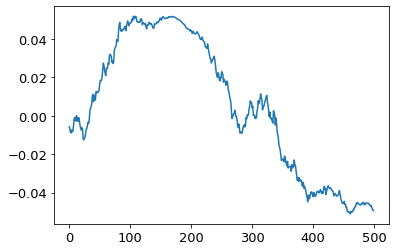

In [116]:
plt.plot(m_th[0,:])

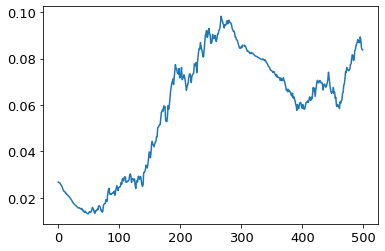

In [117]:
plt.plot(m_th[1,:])

In [118]:
m_th

array([[-5.68874790e-03, -6.29882057e-03, -8.56329694e-03,
        -8.90041246e-03, -7.40419840e-03, -8.21525632e-03,
        -8.14827725e-03, -5.54834038e-03, -1.93949636e-03,
        -9.11743739e-04, -2.18634345e-03, -2.71845959e-03,
         1.42951715e-04, -2.67490551e-03, -8.81321136e-04,
        -2.80391093e-03, -1.07091343e-03, -3.12652241e-03,
        -5.24798310e-03, -6.32055177e-03, -7.44093103e-03,
        -6.22746401e-03, -7.16890044e-03, -1.22898098e-02,
        -1.24779111e-02, -1.16741480e-02, -1.11438128e-02,
        -9.06322624e-03, -6.98537013e-03, -6.48360179e-03,
        -4.92153443e-03, -3.37602116e-03, -3.92711971e-03,
        -1.69236233e-03,  2.71998442e-03,  4.23023220e-03,
         4.75379107e-03,  6.11354177e-03,  1.02037920e-02,
         1.11770537e-02,  7.40148515e-03,  1.07180852e-02,
         9.59239110e-03,  8.20781884e-03,  1.24558338e-02,
         1.19725194e-02,  1.25567702e-02,  1.22001460e-02,
         1.26133239e-02,  1.33149474e-02,  1.63381368e-0

Text(0.5, 1.0, 'Non Reversible Ensemble Kalman Sampler with gradient, J = 100, N = 500')

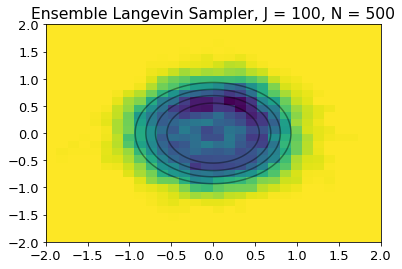

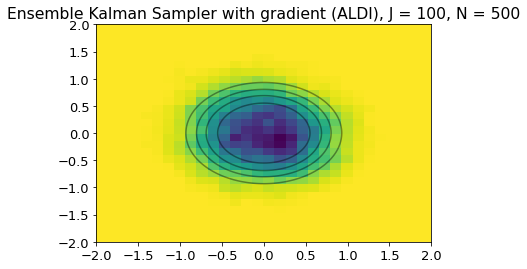

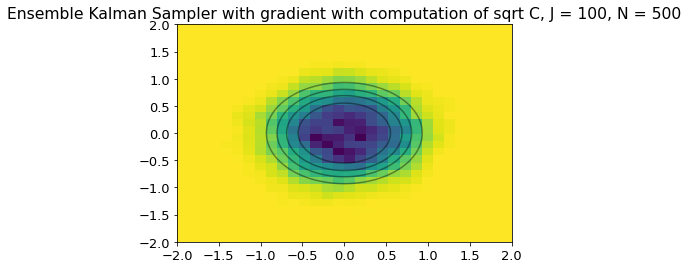

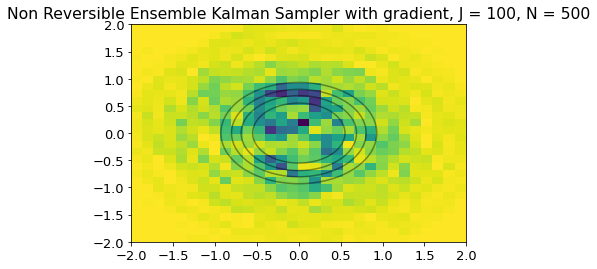

In [119]:
# plot results

N_burnin = 0#1000#int(N_sim/2)


binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)
H1, yedges1, xedges1 = np.histogram2d(us_list_ULA[0,:,N_burnin:].flatten(),us_list_ULA[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
#H2, yedges2, xedges2 = np.histogram2d(us_list_ALDI[0,:,N_burnin:].flatten(),us_list_ALDI[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
H3, yedges3, xedges3 = np.histogram2d(us_list_ALDI2[0,:,N_burnin:].flatten(),us_list_ALDI2[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
H4, yedges4, xedges4 = np.histogram2d(us_list_ALDI3[0,:,N_burnin:].flatten(),us_list_ALDI3[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
H5, yedges5, xedges5 = np.histogram2d(us_list_ALDINR[0,:,N_burnin:].flatten(),us_list_ALDINR[1,:,N_burnin:].flatten(), bins=[binsx,binsy])



plt.figure()
plt.pcolormesh(yedges1, xedges1, H1.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Langevin Sampler, J = "+str(J)+", N = "+str(N_sim))

"""
plt.figure()
plt.pcolormesh(yedges2, xedges2, H2.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Kalman Sampler without gradient, J = "+str(J)+", N = "+str(N_sim))
"""

plt.figure()
plt.pcolormesh(yedges3, xedges3, H3.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Kalman Sampler with gradient (ALDI), J = "+str(J)+", N = "+str(N_sim))


plt.figure()
plt.pcolormesh(yedges4, xedges4, H4.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Kalman Sampler with gradient with computation of sqrt C, J = "+str(J)+", N = "+str(N_sim))


plt.figure()
plt.pcolormesh(yedges5, xedges5, H5.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Non Reversible Ensemble Kalman Sampler with gradient, J = "+str(J)+", N = "+str(N_sim))


In [120]:
us_list_ALDINR[0,:,N_burnin:].flatten()

array([ 0.28139906,  0.23230309,  0.20204973, ..., -0.61337907,
       -0.61466093, -0.61937121])

In [121]:
np.max(us_list_ALDINR[0,:,N_burnin:].flatten())

2.1680349815912865

In [122]:
np.min(us_list_ALDINR[0,:,N_burnin:].flatten())

-2.1884345079597405

In [123]:
np.max(us_list_ALDI3[0,:,N_burnin:].flatten())

1.74481176421648

In [124]:
np.min(us_list_ALDI3[0,:,N_burnin:].flatten())

-2.3015386968802827

(array([  525.,  1785.,  3791.,  6574., 12207., 11334.,  7370.,  4156.,
         1573.,   685.]),
 array([-2.18843451, -1.75278756, -1.31714061, -0.88149366, -0.44584671,
        -0.01019976,  0.42544719,  0.86109413,  1.29674108,  1.73238803,
         2.16803498]),
 <BarContainer object of 10 artists>)

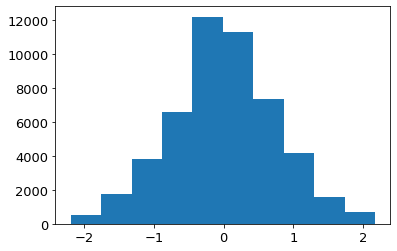

In [125]:
plt.hist(us_list_ALDINR[0,:,N_burnin:].flatten())

In [37]:
us_list_ALDI3[0,:,N_burnin:].flatten()

array([ 1.62434536,  1.28650768,  1.22293214, ..., -0.22873024,
       -0.25811902, -0.21004146])